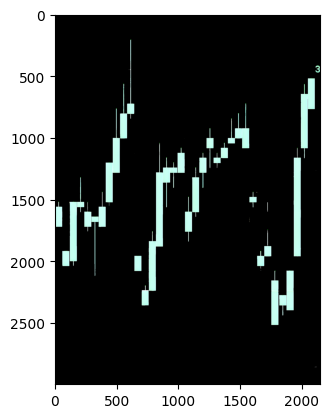

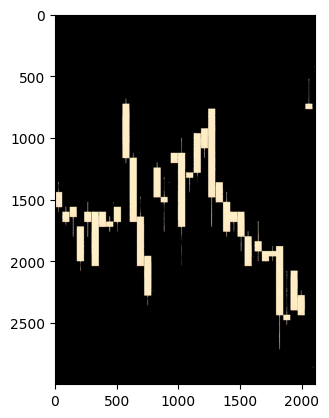

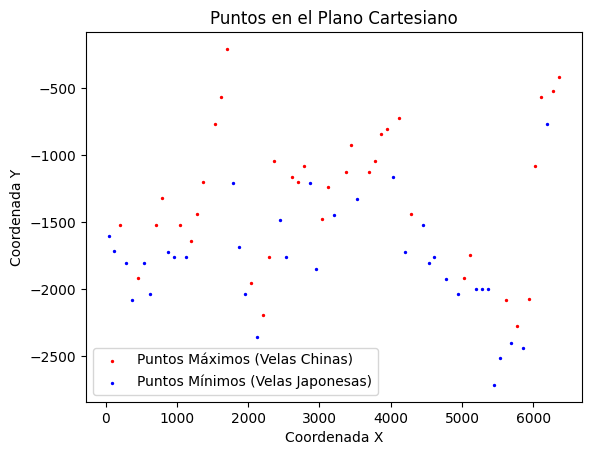

In [2]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def fill_gaps(image, start_point, channel, mask, value, direction, max_gap_length=20, max_search_range=5):
    x, y = start_point
    gap_length = 0

    for i in range(y, 0, direction):
        if 0 <= x < image.shape[1] and 0 <= i < image.shape[0]:  # Check bounds
            if mask[i, x] > 0:
                break
            else:
                gap_length += 1
                if gap_length <= max_gap_length:
                    image[i, x, channel] = value
                    x += 1
                else:
                    # Extensive search to fill gaps
                    for j in range(1, max_search_range + 1):
                        if 0 <= x + j * direction < image.shape[1] and mask[i, x + j * direction] == 0:
                            image[i, x + j * direction, channel] = value
                        else:
                            break
        else:
            break  # Break if the indices go out of bounds

def enhance_color(image, color_mask, brightness_factor=1.5):
    enhanced_color = cv2.addWeighted(image, brightness_factor, cv2.cvtColor(color_mask, cv2.COLOR_GRAY2BGR), 0.5, 0)
    return cv2.bitwise_and(enhanced_color, enhanced_color, mask=color_mask)

def filter_small_columns(image, threshold=2):
    column_sums = np.sum(image, axis=0)
    columns_to_remove = np.where(column_sums <= threshold)[0]
    image_filtered = np.delete(image, columns_to_remove, axis=1)
    return image_filtered

def extract_candlestick_data(image_path="C:/Users/gerar/Downloads/1minuto_upscayl_4x_realesrgan-x4plus.jpg", output_excel_path="candlestick_data.xlsx"):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Ajustar límites de color para velas verdes (velas chinas)
    lower_green = np.array([10, 50, 50])  # Ajustar estos valores
    upper_green = np.array([90, 255, 255])  # Ajustar estos valores

    # Ajustar límites de color para velas rojas (velas japonesas)
    lower_red = np.array([0, 50, 50])  # Ajustar estos valores
    upper_red = np.array([50, 255, 255])  # Ajustar estos valores

    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    red_mask = cv2.inRange(hsv_image, lower_red, upper_red)
    combined_mask = green_mask + red_mask

    # Enhance green candles
    enhanced_green_image = enhance_color(image.copy(), green_mask)

    # Enhance red candles
    enhanced_red_image = enhance_color(image.copy(), red_mask)

    hsv_combined = cv2.cvtColor(cv2.bitwise_and(image, image, mask=combined_mask), cv2.COLOR_BGR2HSV)
    gray_combined = cv2.cvtColor(cv2.bitwise_and(image, image, mask=combined_mask), cv2.COLOR_BGR2GRAY)
    blurred_combined = cv2.GaussianBlur(gray_combined, (5, 5), 0)
    edge_combined = cv2.Canny(blurred_combined, 30, 90, apertureSize=3)

    kernel = np.ones((3, 3), np.uint8)
    closed_edge = cv2.morphologyEx(edge_combined, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed_edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cartesian_max_points = []
    cartesian_min_points = []
    existing_max_points = set()
    existing_min_points = set()
    x_tolerance = 5

    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        mecha_length = min(h, w) // 2

        if mecha_length > 5:
            average_color = np.mean(image[y:y+h, x:x+w], axis=(0, 1))

            if average_color[1] > average_color[2]:
                top_mecha_point = (x + w // 2, y)
                fill_gaps(enhanced_green_image, top_mecha_point, 1, green_mask, enhanced_green_image[top_mecha_point[1], top_mecha_point[0], 1], -1)

                if not any(abs(existing_point - top_mecha_point[0]) < x_tolerance for existing_point in existing_max_points):
                    cv2.circle(enhanced_green_image, top_mecha_point, 2, (0, 255, 0), -1)
                    cartesian_max_points.append((top_mecha_point[0], -top_mecha_point[1]))
                    existing_max_points.add(top_mecha_point[0])
            else:
                bottom_mecha_point = (x + w // 2, y + h)
                fill_gaps(enhanced_red_image, bottom_mecha_point, 2, red_mask, enhanced_red_image[bottom_mecha_point[1], bottom_mecha_point[0], 2], 1)

                # Encuentra el punto más bajo en la región de la mecha inferior
                for i in range(y + h, min(y + h + mecha_length, image.shape[0])):
                    if red_mask[i, x + w // 2] > 0:
                        bottom_mecha_point = (x + w // 2, i)
                        break

                if not any(abs(existing_point - bottom_mecha_point[0]) < x_tolerance for existing_point in existing_min_points):
                    cv2.circle(enhanced_red_image, bottom_mecha_point, 2, (0, 0, 255), -1)
                    cartesian_min_points.append((bottom_mecha_point[0], -bottom_mecha_point[1]))
                    existing_min_points.add(bottom_mecha_point[0])

    # Filter small columns for max and min images
    filtered_max_image = filter_small_columns(enhanced_green_image)
    filtered_min_image = filter_small_columns(enhanced_red_image)

    plt.imshow(cv2.cvtColor(filtered_max_image, cv2.COLOR_BGR2RGB))
    plt.show()

    plt.imshow(cv2.cvtColor(filtered_min_image, cv2.COLOR_BGR2RGB))
    plt.show()

    df = pd.DataFrame({"Coordenada X": [point[0] for point in cartesian_max_points + cartesian_min_points],
                       "Coordenada Y": [point[1] for point in cartesian_max_points + cartesian_min_points],
                       "Tipo de Vela": ["Máxima"] * len(cartesian_max_points) + ["Mínima"] * len(cartesian_min_points)})

    df.to_excel(output_excel_path, index=False)

    plt.scatter(*zip(*cartesian_max_points), color='red', label='Puntos Máximos (Velas Chinas)', s=2)
    plt.scatter(*zip(*cartesian_min_points), color='blue', label='Puntos Mínimos (Velas Japonesas)', s=2)
    plt.title("Puntos en el Plano Cartesiano")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.legend()
    plt.show()

extract_candlestick_data()
